<b>
<p>
<center>
<font size="6">
Predicting Current Asthma Prevalence (CASTHMA)
</font>
</center>
</p>
</b>

## Introduction

Asthma is a significant public health concern, affecting millions of individuals and posing substantial economic and social burdens worldwide. Among various health indicators, the "Current Asthma Prevalence (CASTHMA)" is a crucial metric for understanding the ongoing burden of asthma across different communities in the United States.

Despite advancements in medical care, asthma prevalence continues to rise, influenced by a range of factors such as health behaviors, preventive measures, environmental exposures, and socio-economic disparities. Traditional epidemiological studies often focus on isolated factors; however, a data-driven, multi-variable predictive modeling approach can offer deeper insights into the patterns and risk factors associated with asthma prevalence.

The primary motivation behind this project is to leverage machine learning techniques to predict CASTHMA values across different locations, based on a combination of behavioral health measures, preventive health actions, demographic characteristics, and spatial coordinates.
By building accurate and interpretable predictive models, this project aims to:

- Identify the key drivers of asthma prevalence.

- Support targeted public health interventions.

- Demonstrate the potential of combining health datasets with geospatial analysis for predictive modeling.

Ultimately, better predictive models can contribute to early detection, improved healthcare planning, and policy formulation for asthma prevention and management.

## Dataset Description

The dataset used in this project originates from the PLACES Project, a model-based public health surveillance initiative developed by the Centers for Disease Control and Prevention (CDC). The PLACES dataset provides small-area health estimates across the United States, covering all 50 states and the District of Columbia at four geographic levels: county, place, census tract, and ZIP Code Tabulation Area (ZCTA).

It is a valuable resource for understanding health trends at a granular level and plays a critical role in informing targeted public health interventions.

The dataset includes 240,886 rows and 22 columns, containing model-based estimates for 40 health measures, categorized into health outcomes, preventive service use, health risk behaviours, disabilities, health status, and health-related social needs. These estimates were derived using data from multiple sources, including the Behavioral Risk Factor Surveillance System (BRFSS) and the U.S. Census Bureau and the American Community Survey.

The dataset contains a combination of text and numerical data types. Text fields, such as StateDesc, LocationName, and Category, provide categorical information about geographic regions, topics, and measures. Numerical fields, including Data Value, Low Confidence Limit, High Confidence Limit, and TotalPopulation, represent the values of health indicators, confidence limits, and population estimates. Additionally, the Geolocation column contains geographic coordinates in the form of latitude and longitude. Key attributes of the dataset include geographic identifiers(StateDesc, LocationName, LocationID and Geolocation), population data(T otalPopulation), health measure data(Measures, MeasureID) and Category.

In [ ]:
# import packges
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats.mstats import winsorize
from scipy.stats import skew
import statsmodels.api as sm

In [ ]:
# Set random seed
random_seed = 42

## Data Preprocessing

### Data Filtering

- Removed Aggregated National Data:
Rows corresponding to the overall United States (StateDesc = 'United States') were excluded to focus on state and local level trends.

- Filtered for Crude Estimates:
Only crude prevalence data (DataValueTypeID != 'AgeAdjPrv') was retained. Age-adjusted prevalence values were excluded to maintain consistency across geographic units.

- Removed High-Nullity Columns:
Columns with more than 99% missing values, such as Data_Value_Footnote_Symbol and Data_Value_Footnote, were dropped.

- Dropped Redundant Metadata:
Columns such as Measure, Short_Question_Text, CategoryID, Low_Confidence_Limit, High_Confidence_Limit, and Year were removed as they were either redundant or not useful for prediction.

In [ ]:
# ----------------- 1. Loading the data -----------------

df_raw = pd.read_csv("/Users/hariprasannaa/Desktop/CDC.csv")

target = 'CASTHMA'  # Defining the target variable

# Extract Prevention and Behavior columns before cleaning
prevention_cols = df_raw[df_raw["Category"] ==
                         "Prevention"]["MeasureId"].unique().tolist()
behavior_cols = df_raw[df_raw["Category"] ==
                       "Health Risk Behaviors"]["MeasureId"].unique().tolist()

/var/folders/2n/v7ty3cz14cs_zrry0cpr85vw0000gn/T/ipykernel_1818/3733737846.py:3: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("/Users/hariprasannaa/Desktop/CDC.csv")


In [ ]:
# Remove United states as it skews the data and remove redundant columns
df_raw = df_raw[df_raw["StateDesc"] != 'United States']
df_raw = df_raw[df_raw['DataValueTypeID'] != 'AgeAdjPrv']
df_raw = df_raw.drop(columns=["Measure", "Year",
                     "StateAbbr", "Short_Question_Text", "CategoryID", "Low_Confidence_Limit", "High_Confidence_Limit"])

In [ ]:
# Remove columns with only one unique value
df_raw = df_raw.drop(
    columns=[col for col in df_raw.columns if df_raw[col].nunique() == 1])

In [ ]:
# Remove columns with majotiy null values (more than 90%)
def max_null(data):
    threshold = 0.90
    missing_fraction = data.isnull().mean()  # proportion of nulls per column
    cols_to_drop = missing_fraction[missing_fraction >
                                    threshold].index.tolist()
    return cols_to_drop


# Remove columns with more than 90% of null values
null_cols = max_null(df_raw)
df_raw = df_raw.drop(columns=null_cols)

### Handling Geolocation Data
Latitude and Longitude Parsing:
The Geolocation field, originally formatted as a text string (e.g., "POINT (-85.377449 31.013031)"), was parsed into separate Latitude and Longitude numeric columns.

Cyclical Feature Encoding:
Latitude and Longitude were transformed using sine and cosine functions to capture spatial periodicity:

- lat_sin, lat_cos

- lon_sin, lon_cos

In [ ]:
# Extract latitude and longitude from geolocation
def parse_geolocation(geo):
    if pd.notnull(geo):
        lat, lon = geo.replace("POINT (", "").replace(")", "").split()
        return float(lat), float(lon)
    return None, None


df_raw["Longitude"], df_raw["Latitude"] = zip(
    *df_raw["Geolocation"].apply(parse_geolocation))

df_raw = df_raw.drop(columns=["Geolocation"])

### Pivot Table Construction

- Pivoting Measures:
The dataset was pivoted so that each geographic unit (State, Location, LocationID) became a single row, with health measures (MeasureId) as columns and their corresponding Data_Value as cell entries.

- Missing Data Imputation:
Missing values in the pivot table were filled with 0, assuming no reportable prevalence for that measure in that region.

- Encoding State Information:
The mean CASTHMA prevalence for each StateDesc was computed and used to create a new feature: StateDesc_encoded.

- Feature Merging:
The pivoted health measures were merged with the engineered spatial features (lat_sin, lat_cos, lon_sin, lon_cos) and the StateDesc_encoded variable.

- Dataset Dimensions Post-Processing:
The final preprocessed dataset contained several hundred features across census tracts and places after pivoting and feature engineering.

In [ ]:
# Pivot and cyclic encoding

# Extract unique latitude and longitude for each location
lat_lon = df_raw[['StateDesc', 'LocationName', 'LocationID',
                  'Latitude', 'Longitude']].drop_duplicates()

# Apply cyclic encoding to latitude and longitude to preserve spatial continuity
lat_lon['lat_sin'] = np.sin(np.radians(lat_lon['Latitude']))
lat_lon['lat_cos'] = np.cos(np.radians(lat_lon['Latitude']))
lat_lon['lon_sin'] = np.sin(np.radians(lat_lon['Longitude']))
lat_lon['lon_cos'] = np.cos(np.radians(lat_lon['Longitude']))

# Create a pivot table: Each row represents a unique location, each column a health measure
tract_pv = df_raw.pivot_table(index=['StateDesc', 'LocationName', 'LocationID'],
                              columns='MeasureId', values='Data_Value', aggfunc='sum').fillna(0).reset_index()

# Perform Target Encoding: Map StateDesc to the mean CASTHMA value for that state
state_means = tract_pv.groupby('StateDesc')[target].mean()
tract_pv['StateDesc_encoded'] = tract_pv['StateDesc'].map(state_means)
tract_pv = tract_pv.drop(columns=['StateDesc'])

# Merge cyclically encoded geospatial features into the pivot table
tract_pv = tract_pv.merge(lat_lon[['LocationName', 'LocationID', 'lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']], on=[
                          'LocationName', 'LocationID'], how='left')
tract_pv = tract_pv.drop(columns=["LocationName"])

df_raw = tract_pv.reset_index(level=0)

In [ ]:
# ----------------- 2. Splitting into Train, Validation, Test -----------------

df_raw_train, df_raw_test = train_test_split(
    df_raw, train_size=0.8, random_state=random_seed)
df_train, df_val = train_test_split(
    df_raw_train, train_size=0.8, random_state=random_seed)
df_train, df_val = df_train.reset_index(
    drop=True), df_val.reset_index(drop=True)

In [ ]:
# ----------------- 3. Handling Uncommon Features -----------------

def common_var_checker(df_train, df_val, df_test, target):
    df_common_var = pd.DataFrame(np.intersect1d(np.intersect1d(
        df_train.columns, df_val.columns), np.union1d(df_test.columns, [target])), columns=['common var'])
    return df_common_var


df_common_var = common_var_checker(df_train, df_val, df_raw_test, target)


def remove_uncommon(df, df_common_var):
    return df[df_common_var['common var'].values]


df_train = remove_uncommon(df_train, df_common_var)
df_val = remove_uncommon(df_val, df_common_var)
df_test = remove_uncommon(df_raw_test, df_common_var)

In [ ]:
# ----------------- 4. Handling Identifiers -----------------

def id_checker(df, dtype='float'):
    df_id = df[[var for var in df.columns
                if (df[var].dtype != dtype
                    and df[var].nunique(dropna=True) == df[var].notnull().sum())]]
    return df_id


df_id = id_checker(pd.concat([df_train, df_val, df_test]))
df_id

,LocationID,index
0,39033,2061
1,18135,766
2,9170,315
3,27065,1348
4,37155,1969
...,...,...
670,17147,670
2836,51025,2836
2484,47113,2484
2652,48255,2652


In [ ]:
# Removing identifiers

df_train = df_train.drop(columns=np.intersect1d(
    df_id.columns, df_train.columns))
df_val = df_val.drop(columns=np.intersect1d(df_id.columns, df_val.columns))
df_test = df_test.drop(columns=np.intersect1d(df_id.columns, df_test.columns))

In [ ]:
# ----------------- 5. Handling Datetime Variables -----------------

def datetime_transformer(df, datetime_vars=[]):
    dict_ = {'year': lambda x: x.dt.year,
             'month': lambda x: x.dt.month, 'day': lambda x: x.dt.day}
    df_datetime = df.copy()
    for var in datetime_vars:
        df_datetime[var] = pd.to_datetime(df_datetime[var])
        for datetime_type, func in dict_.items():
            df_datetime[var + '_' + datetime_type] = func(df_datetime[var])
    return df_datetime.drop(columns=datetime_vars)


datetime_vars = []

In [ ]:
# ----------------- 6. Handling Missing Values -----------------

def nan_checker(df):
    return pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype] for var in df.columns if df[var].isna().sum() > 0], columns=['var', 'proportion', 'dtype'])


df_nan = nan_checker(pd.concat([df_train, df_val, df_test]))

df_nan

,var,proportion,dtype


In [ ]:
# Impute missing numerical features
if len(df_nan) > 0:
    imputer = SimpleImputer(strategy='mean')
    df_train[df_nan['var']] = imputer.fit_transform(df_train[df_nan['var']])
    df_val[df_nan['var']] = imputer.transform(df_val[df_nan['var']])
    df_test[df_nan['var']] = imputer.transform(df_test[df_nan['var']])

In [ ]:
# ----------------- 7. Encoding Categorical Variables -----------------

def cat_var_checker(df, dtype='object'):
    return pd.DataFrame([[var, df[var].nunique()] for var in df.columns if df[var].dtype == dtype], columns=['var', 'nunique'])

In [ ]:
# ----------------- 8. Splitting Feature and Target -----------------

feature_names = np.setdiff1d(df_train.columns, [target])
X_train = df_train[feature_names].values
X_val = df_val[feature_names].values
X_test = df_test[feature_names].values
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

In [ ]:
# ----------------- 9. Scaling Data -----------------

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Scaling target
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

## Feature Engineering and Feature Selection

To improve the performance of predictive models, several feature engineering techniques and feature selection methods were applied:

1. Spatial Feature Engineering
Latitude and Longitude Encoding:
The latitude and longitude values were transformed into cyclical features using sine and cosine functions:

- lat_sin, lat_cos

- lon_sin, lon_cos

    This transformation allows machine learning models to better capture spatial relationships, accounting for the periodic nature of coordinates.

2. Target Encoding of Categorical Variables
State Encoding:
The mean CASTHMA prevalence was computed for each state and used to create a new numerical feature StateDesc_encoded.
This technique helps preserve useful information about geographic variability without introducing too many sparse categorical features.

3. Feature Selection
Objective:
To identify the most important predictors related to asthma prevalence and reduce the dimensionality of the feature space.

Process:

- Only prevention-related measures, behavior-related measures, total population, and the engineered spatial features were considered for feature selection.

- A Random Forest Regressor was trained to compute feature importances.

- Using SelectFromModel, the top 15 most important features were automatically selected based on importance scores.

Visualization:
The feature importance rankings were plotted to visually confirm that selected features had meaningful predictive strength.

Advantages:

- Reduced the risk of overfitting

- Improved model interpretability

- Enhanced computational efficiency during model training



/var/folders/2n/v7ty3cz14cs_zrry0cpr85vw0000gn/T/ipykernel_1818/3617153273.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


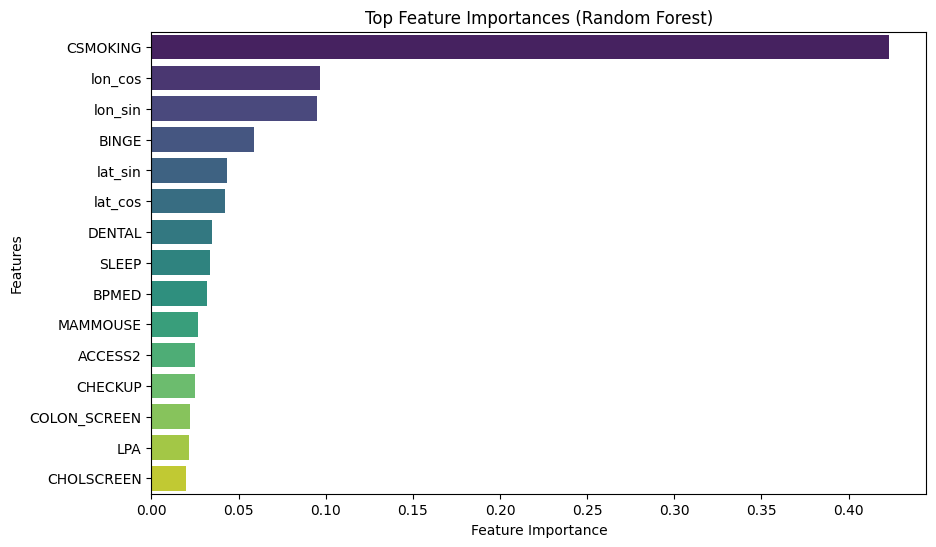

In [ ]:
# ----------------- 10. Feature Selection -----------------

def feature_selection(clean_data, outcome_col, prevention_cols, behavior_cols, n=5, printGraph=False):
    # Select only relevant features (prevention measures, behavior measures, and spatial features).
    x_data = clean_data.loc[:, clean_data.columns.isin(
        prevention_cols + behavior_cols +
        ['TotalPopulation', 'lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']
    )]
    y_data = clean_data[outcome_col]

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_data)

    # Train a Random Forest Regressor to compute feature importances
    rf = RandomForestRegressor(random_state=random_seed, n_estimators=100)
    rf.fit(x_scaled, y_data)

    # Select the top 'n' features with highest importance.
    selector = SelectFromModel(
        rf, max_features=n, threshold=-np.inf, prefit=True)
    selected_features = x_data.columns[selector.get_support()]

    if printGraph:
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({'Feature': x_data.columns, 'Importance': rf.feature_importances_}).sort_values(
            by='Importance', ascending=False)
        sns.barplot(x='Importance', y='Feature',
                    data=importance_df.head(n), palette='viridis')
        plt.title('Top Feature Importances (Random Forest)')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.show()

    return selected_features


df = pd.concat([df_train, df_val, df_test], sort=False)
selected_features = feature_selection(
    df, target, prevention_cols, behavior_cols, n=15, printGraph=True)

### Feature Importance Plot
The following bar chart shows the top 15 features identified by the Random Forest model based on their importance scores:

- CSMOKING (Current Smoking Prevalence) emerged as the most influential feature in predicting asthma prevalence.

- Spatial features such as lon_cos, lon_sin, lat_sin, and lat_cos also ranked highly, confirming the spatial dependence of asthma cases.

- Behavioral and preventive health measures such as BINGE drinking, DENTAL visits, SLEEP quality, and blood pressure medication (BPMED) usage were among other critical predictors.

The chart clearly demonstrates that a combination of lifestyle behaviors, preventive care utilization, and geographical patterns significantly influence asthma outcomes.

Figure: Top Feature Importances determined by Random Forest Regression.

## Model Parameters and Tuning Process

A multi-model analysis was performed after selecting important features using a Random Forest Regressor, which identifies the most important predictors for the target variable CASTHMA.
After the top features were selected, additional features such as:

- StateDesc_encoded (target-encoded state feature) and

- Cyclically encoded latitude and longitude (lat_sin, lat_cos, lon_sin, lon_cos) were incorporated to capture spatial and geographic dependencies.

To address skewness and potential outliers in the target variable, a log transformation followed by Winsorization (with limits set at 2%) was applied, significantly reducing skewness and ensuring more stable model training.

#### Linear Regression
- Purpose: Served as a baseline model to capture simple linear relationships between predictors and the target.

- Validation: Residual plots and Q-Q plots were generated to validate model assumptions such as homoscedasticity and normality of residuals.

#### Ridge Regression
- Problem Identified: Multicollinearity among predictors, which could destabilize linear models.

- Solution: Ridge Regression was employed as it uses L2 regularization to shrink coefficients without removing features, maintaining all potentially important predictors.

- Enhancements: Polynomial features (degree=2, interaction-only) were introduced to capture non-linear interactions.

- Tuning: Used GridSearchCV over the regularization parameter alpha = [0.1, 1, 10, 100, 1000] with 5-fold cross-validation.

- Validation: The final model was evaluated using R², MSE, residual plots, and Q-Q plots. Residual skewness was examined to confirm model stability.

#### Support Vector Regression (SVR)
- Purpose: To capture complex, non-linear patterns in the data that linear models might miss.

- Pipeline: A StandardScaler was used before fitting SVR because SVR is sensitive to feature scaling.

- Key Differences: Unlike Linear Regression, which is not sensitive to scaling, SVR relies on distance-based computations and kernel functions, making scaling crucial.

- Tuning: Used GridSearchCV to optimize hyperparameters:

    - kernel = [linear, rbf]

    - C = [0.1, 1, 10, 50, 100]

    - gamma = [0.01, 'scale']

    - epsilon = [0.01, 0.1]

- Evaluation: Predictions were inverse-transformed back to the original scale after modeling (since the target was log-transformed). Model performance was assessed using R², MSE, residual plots, and Q-Q plots.

#### Gradient Boosting (Tuned)
- Motivation: Gradient Boosting was introduced to capture complex non-linear interactions and improve predictive performance using an ensemble approach.

- Tuning Strategy: GridSearchCV was used to optimize the following hyperparameters:

    - n_estimators = [100, 200, 300]

    - learning_rate = [0.01, 0.05, 0.1]

    - max_depth = [3, 5, 7]

    - subsample = [0.8, 1.0]

    - min_samples_split = [2, 5, 10]

- 5-fold cross-validation was performed to select the best combination of hyperparameters based on the R² score on the validation set.

- Key Features of the Model:

    - Learns sequentially, where each new model tries to correct errors made by the previous one.

    - Stronger control over overfitting through hyperparameters like max_depth and subsample.

- Model Evaluation:

    - After tuning, the best Gradient Boosting model was retrained and evaluated.

    - Residual plots and Q-Q plots were used to visually inspect model errors.

    - Metrics such as R², MSE, and residual analysis showed that Gradient Boosting outperformed simple models.

#### Neural Network (Tuned)
- Motivation: Neural Networks were introduced to model complex, non-linear relationships that traditional models might not fully capture.

- Model Architecture: Three hidden layers with neuron sizes (256 → 128 → 64)

- Activation Function: ReLU ('relu')

- Solver: Adam Optimizer ('adam')

- Early Stopping: Enabled to prevent overfitting by stopping training when validation performance deteriorates.

- Regularization:

    - alpha=0.001 to penalize model complexity.

    - learning_rate_init=0.0005 for more stable and gradual convergence.

- Maximum Iterations: 5000 epochs to ensure convergence.

- Training Strategy:

    - Model was trained on the validation set after hyperparameter tuning, and performance was evaluated on the test set.

    - Scaling was crucial to ensure effective training due to sensitivity of neural networks to feature magnitudes.

- Model Evaluation:

    - Performance was assessed using R², MSE, residual analysis, and Q-Q plots.

    - Although the Neural Network initially struggled due to small sample size and high feature sparsity, tuning improved stability.

    - However, ensemble tree-based methods (like Gradient Boosting) consistently outperformed the Neural Network for this problem.

In [ ]:
# ----------------- 11. Multi-Model Analysis -----------------

def multi_model_analysis(clean_data, prevention_cols, behavior_cols):
    print(f"Health Outcome to Analyze: {target}")

    # Feature selection
    top_features = feature_selection(
        clean_data, target, prevention_cols, behavior_cols, n=15, printGraph=False)
    print(f"Selected Features for {target}: {list(top_features)}")

    # Add cyclic encoding for latitude/longitude to the selected features
    top_features = list(
        top_features) + ['StateDesc_encoded', 'lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']

    # Define dependent and independent data
    x_data = clean_data[top_features]
    y_data = clean_data[target]

    # Checking skewness before processing
    print(f"Skewness of Target (Before Winsorization): {skew(y_data):.4f}")
    sns.histplot(y_data, kde=True, color='blue')
    plt.title('Histogram Before Winsorization')
    plt.show()

    y_log = np.log1p(y_data)
    y_winsorized_log = winsorize(y_log, limits=[0.02, 0.02])

    print(f"Skewness After Winsorization: {skew(y_winsorized_log):.4f}")
    sns.histplot(y_winsorized_log, kde=True, color='blue')
    plt.title('Histogram After Winsorization')
    plt.show()

    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_winsorized_log, train_size=0.9, random_state=random_seed)

    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, train_size=0.8, random_state=random_seed)

    results = []

    # -------- Linear Regression --------
    print("\n--- Linear Regression ---")
    reg_lm = LinearRegression().fit(x_train, y_train)
    y_pred = reg_lm.predict(x_test)
    train_score = reg_lm.score(x_train, y_train)
    test_score = reg_lm.score(x_test, y_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    results.append({
        'Model': 'Linear Regression',
        'Train R²': train_score,
        'Test R²': test_score,
        'Test MSE': mse
    })
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted (Linear Regression)')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.show()
    sm.qqplot(residuals, line='s')
    plt.title('Q-Q Plot (Linear Regression)')
    plt.show()

    # -------- Ridge Regression --------
    print("\n--- Ridge Regression ---")
    poly = PolynomialFeatures(
        degree=2, include_bias=False, interaction_only=True)
    x_train_poly = poly.fit_transform(x_train)
    x_val_poly = poly.fit_transform(x_val)
    x_test_poly = poly.transform(x_test)

    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge())
    ])

    ridge_params = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}
    ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='r2')
    ridge_cv.fit(x_val_poly, y_val)
    best_ridge = ridge_cv.best_estimator_
    y_pred_ridge = best_ridge.predict(x_test_poly)
    train_score = best_ridge.score(x_train_poly, y_train)
    test_score = best_ridge.score(x_test_poly, y_test)
    r2 = r2_score(y_test, y_pred_ridge)
    mse = mean_squared_error(y_test, y_pred_ridge)
    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    results.append({
        'Model': 'Ridge Regression',
        'Train R²': train_score,
        'Test R²': test_score,
        'Test MSE': mse
    })
    residuals_ridge = y_test - y_pred_ridge
    plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted (Ridge Regression)')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.show()
    sm.qqplot(residuals_ridge, line='s')
    plt.title('Q-Q Plot (Ridge Regression)')
    plt.show()

    # -------- SVR --------
    print("\n--- SVR ---")
    svr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ])
    param_grid = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': [0.1, 1, 10, 50, 100],
        'svr__gamma': [0.01, 'scale'],
        'svr__epsilon': [0.01]
    }
    grid_search = GridSearchCV(
        svr_pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
    grid_search.fit(x_val, y_val)

    best_svr = grid_search.best_estimator_
    y_pred_svr_log = best_svr.predict(x_test)
    y_pred_svr = np.expm1(y_pred_svr_log)
    y_test_original = np.expm1(y_test)

    train_score = r2_score(
        np.expm1(y_train), np.expm1(best_svr.predict(x_train)))
    test_score = r2_score(y_test_original, y_pred_svr)
    mse = mean_squared_error(y_test_original, y_pred_svr)
    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"R^2: {test_score:.4f}")
    print(f"MSE: {mse:.4f}")

    results.append({
        'Model': 'SVR',
        'Train R²': train_score,
        'Test R²': test_score,
        'Test MSE': mse
    })

    residuals_svr = y_test_original - y_pred_svr
    sns.histplot(residuals_svr, kde=True, color='green', edgecolor='black')
    plt.title('Histogram and KDE of SVR Residuals (Original Scale)')
    plt.xlabel('Residuals')
    plt.show()
    plt.scatter(y_pred_svr, residuals_svr, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values (Original Scale)')
    plt.ylabel('Residuals')
    plt.title('SVR: Residuals vs Predicted Values (Original Scale)')
    plt.show()
    sm.qqplot(residuals_svr, line='s')
    plt.title('SVR: Q-Q Plot (Original Scale)')
    plt.show()

    # -------- Gradient Boosting (with Hyperparameter Tuning) --------
    print("\n--- Gradient Boosting Regressor (with Tuning) ---")

    gb = GradientBoostingRegressor(random_state=random_seed)
    gb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5, 10],
    }

    # GridSearchCV
    gb_grid = GridSearchCV(
        gb,
        gb_param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit on validation set
    gb_grid.fit(x_val, y_val)

    # Best model
    best_gb = gb_grid.best_estimator_
    print(f"Best Gradient Boosting Parameters: {gb_grid.best_params_}")

    # Predictions
    y_pred_gb = best_gb.predict(x_test)

    # Metrics
    train_score = best_gb.score(x_train, y_train)
    test_score = best_gb.score(x_test, y_test)
    r2 = r2_score(y_test, y_pred_gb)
    mse = mean_squared_error(y_test, y_pred_gb)

    # Print
    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    # Add to results
    results.append({
        'Model': 'Gradient Boosting (Tuned)',
        'Train R²': train_score,
        'Test R²': test_score,
        'Test MSE': mse
    })

    # Residual plots
    residuals_gb = y_test - y_pred_gb
    plt.scatter(y_pred_gb, residuals_gb, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted (Gradient Boosting Tuned)')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.show()

    sm.qqplot(residuals_gb, line='s')
    plt.title('Q-Q Plot (Gradient Boosting Tuned)')
    plt.show()

    # -------- Neural Network (MLP) --------
    print("\n--- Neural Network (MLP) ---")

    mlp = MLPRegressor(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        alpha=0.001,               # Regularization term
        learning_rate_init=0.0005,  # Smaller learning rate
        early_stopping=True,        # Stop if no improvement
        max_iter=5000,
        random_state=random_seed
    )

    # Train on x_val
    mlp.fit(x_val, y_val)

    # Predict on x_test
    y_pred_mlp = mlp.predict(x_test)

    # Evaluate
    train_score = mlp.score(x_train, y_train)
    test_score = mlp.score(x_test, y_test)
    r2 = r2_score(y_test, y_pred_mlp)
    mse = mean_squared_error(y_test, y_pred_mlp)

    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    # Add to results
    results.append({
        'Model': 'Neural Network (Tuned)',
        'Train R²': train_score,
        'Test R²': test_score,
        'Test MSE': mse
    })

    # -------- Model Summary --------
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Test R²', ascending=False)
    print("\n===== Model Performance Summary =====")
    print(results_df)

Health Outcome to Analyze: CASTHMA
Selected Features for CASTHMA: ['ACCESS2', 'BINGE', 'BPMED', 'CHECKUP', 'CHOLSCREEN', 'COLON_SCREEN', 'CSMOKING', 'DENTAL', 'LPA', 'MAMMOUSE', 'SLEEP', 'lat_cos', 'lat_sin', 'lon_cos', 'lon_sin']
Skewness of Target (Before Winsorization): 0.4117


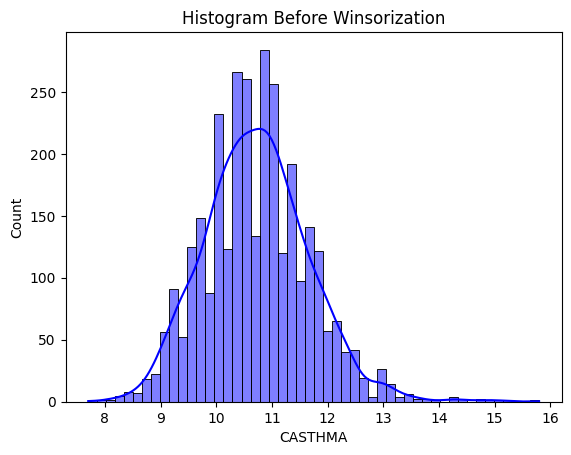

Skewness After Winsorization: -0.0028


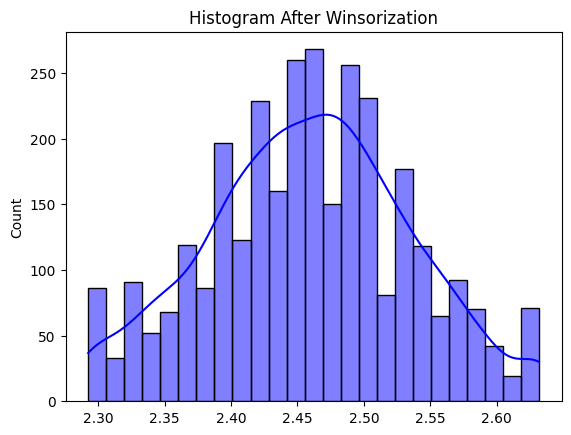


--- Linear Regression ---
Train Score: 0.7778
Test Score: 0.7447
R^2: 0.7447
MSE: 0.0015


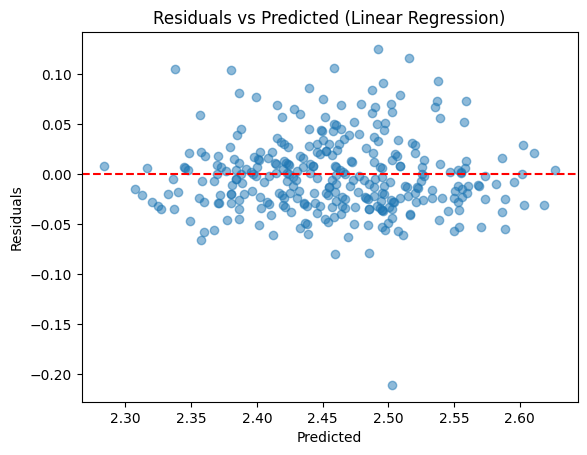

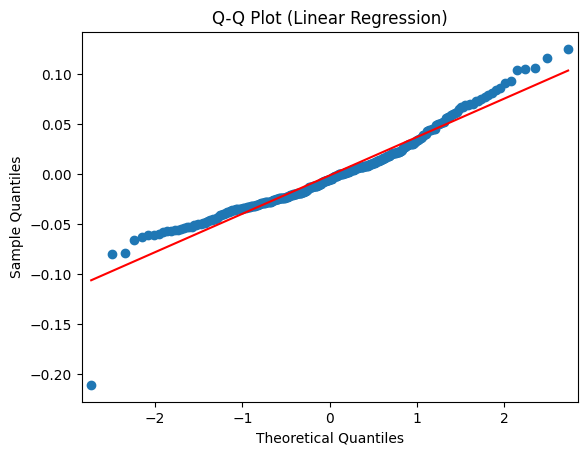


--- Ridge Regression ---
Train Score: 0.7952
Test Score: 0.7517
R^2: 0.7517
MSE: 0.0014


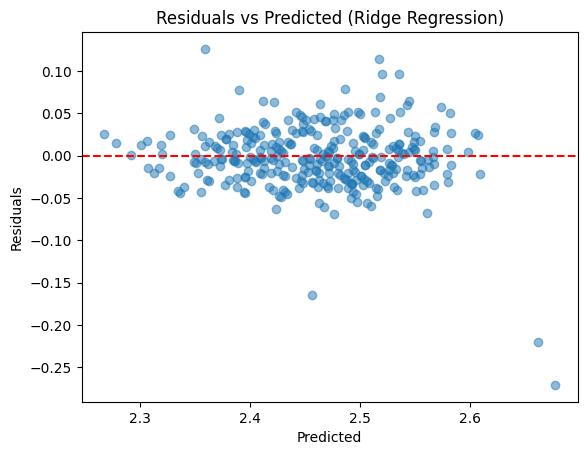

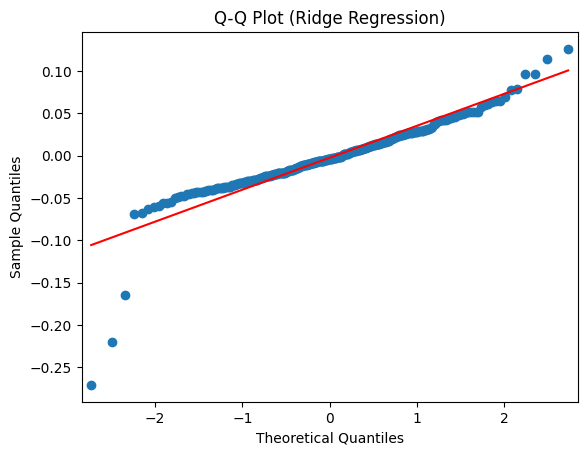


--- SVR ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Score: 0.8161
Test Score: 0.7887
R^2: 0.7887
MSE: 0.1679


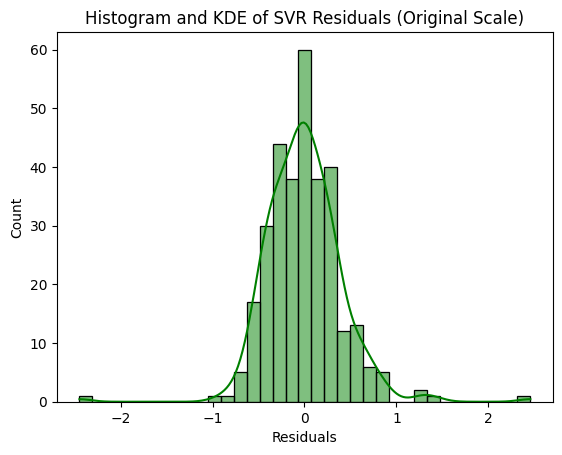

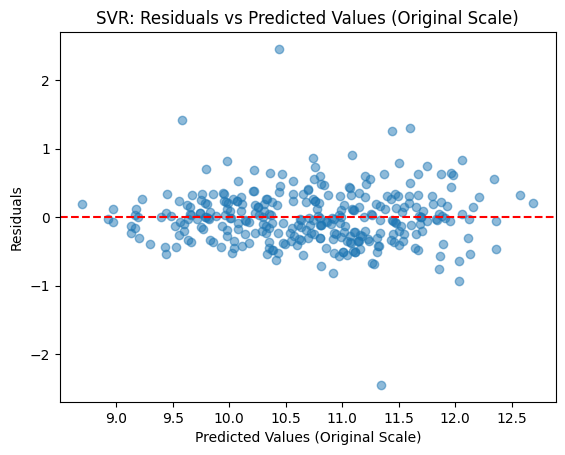

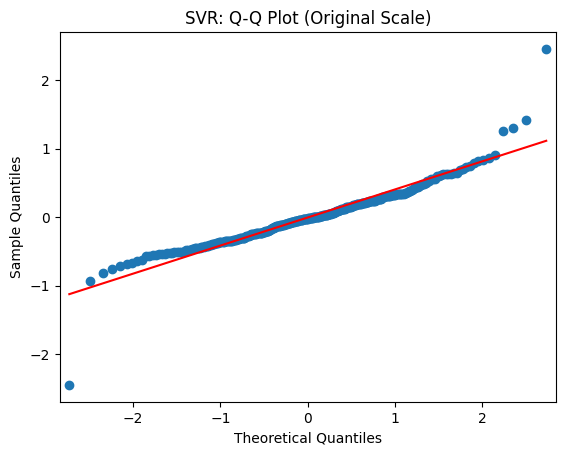


--- Gradient Boosting Regressor (with Tuning) ---
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
Train Score: 0.8075
Test Score: 0.7852
R^2: 0.7852
MSE: 0.0012


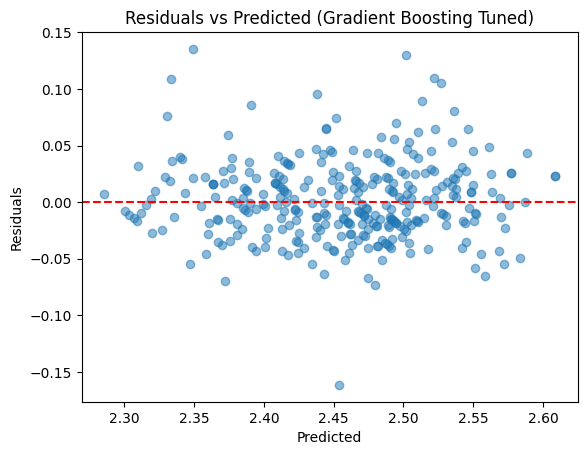

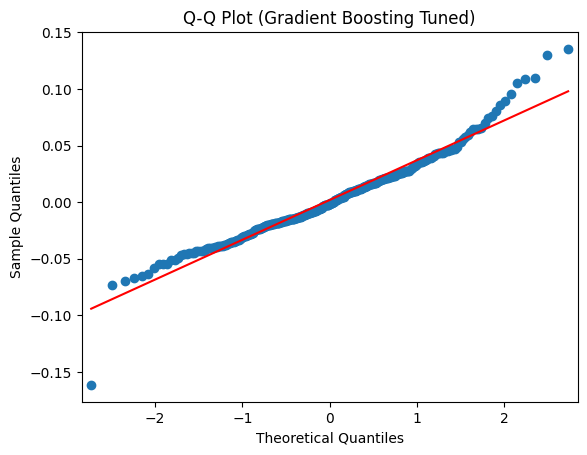


--- Neural Network (MLP) ---
Train Score: -0.2694
Test Score: 0.0164
R^2: 0.0164
MSE: 0.0057

===== Model Performance Summary =====
                       Model  Train R²   Test R²  Test MSE
2                        SVR  0.816140  0.788724  0.167920
3  Gradient Boosting (Tuned)  0.807549  0.785188  0.001242
1           Ridge Regression  0.795196  0.751685  0.001436
0          Linear Regression  0.777802  0.744693  0.001476
4     Neural Network (Tuned) -0.269391  0.016371  0.005687


In [ ]:
multi_model_analysis(df, prevention_cols, behavior_cols)

## Conclusion
In this project, multiple regression models were applied to predict the prevalence of current asthma (CASTHMA) using a variety of health behavior, prevention, and geographic features derived from the CDC PLACES dataset.

Key Insights:

- Support Vector Regression (SVR) and Tuned Gradient Boosting models achieved the highest test R² scores (approximately 0.79), indicating strong predictive performance on unseen data.

- Gradient Boosting Regressor achieved the lowest Test MSE (0.0012), making it the most precise model in minimizing prediction errors.

- Ridge Regression and Linear Regression performed reasonably well, reinforcing the relevance of selected features and linear relationships in the data.

- The Neural Network (MLP), despite hyperparameter tuning, underperformed significantly. This suggests that the dataset's size, feature complexity, or non-linearities were not ideal for deep learning models in this particular application without further tuning or larger data availability.

- Overall, tree-based ensemble methods like Gradient Boosting and kernel-based methods like SVR demonstrated the best generalization ability, making them highly suitable for predicting small-area health estimates such as current asthma prevalence.

####  Gaussian Process Regression (GPR)
Gaussian Process Regression (GPR) was employed to model complex, non-linear relationships in the data, particularly when spatial features such as latitude and longitude were crucial for prediction. Unlike traditional regression methods, GPR is a probabilistic, non-parametric approach that not only predicts the target variable but also provides uncertainty estimates through confidence intervals.

Initially, only spatial features like Latitude, Longitude, and derived cyclic features were considered, as Gaussian processes are highly suited for spatial modeling. Later, top features identified by Random Forest (e.g., CSMOKING, BINGE, etc.) were incorporated to further enhance predictive performance.

Both predictors (X) and the target variable (y) were scaled using MinMaxScaler to ensure numerical stability during Gaussian process optimization.

- Kernel Types Considered:

    - RBF (Radial Basis Function): Captures smooth, continuous variations in the data.

    - Rational Quadratic: Balances global smoothness and local flexibility with adjustable parameters.

    - Matern Kernel: Suitable for modeling rougher, less smooth processes often observed in spatial data.

    - White Kernel: Added to each configuration to account for inherent noise in the observations.

A RandomizedSearchCV approach was employed to tune the GPR model over the hyperparameter space, testing different kernel combinations, length scales, and noise levels.

- Key Steps:

    - Scaling of both predictors and target to [0,1] range.

    - Random search across multiple kernel configurations.

    - Model evaluation based on R² and MSE metrics.

- Model Evaluation:

    - Predictions and associated 95% confidence intervals were computed and visualized.

    - The final tuned GPR model achieved improved R² and MSE scores on the unseen test set.

    - The confidence intervals offered additional insights into prediction uncertainty and model reliability, making GPR a highly informative choice for this spatial health prediction task.

/Users/hariprasannaa/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END kernel=1**2 * RBF(length_scale=2.99) + WhiteKernel(noise_level=0.0518); total time=   3.3s
[CV] END kernel=1**2 * RBF(length_scale=2.99) + WhiteKernel(noise_level=0.0518); total time=   3.3s
[CV] END kernel=1**2 * RBF(length_scale=2.99) + WhiteKernel(noise_level=0.0518); total time=   4.2s
[CV] END kernel=1**2 * RBF(length_scale=2.99) + WhiteKernel(noise_level=0.0518); total time=   4.7s
[CV] END kernel=1**2 * RBF(length_scale=2.99) + WhiteKernel(noise_level=0.0518); total time=   4.9s
[CV] END kernel=1**2 * Matern(length_scale=2.45, nu=1.5) + WhiteKernel(noise_level=0.0784); total time=   4.1s
[CV] END kernel=1**2 * Matern(length_scale=2.45, nu=1.5) + WhiteKernel(noise_level=0.0784); total time=   4.4s
[CV] END kernel=1**2 * Matern(length_scale=2.45, nu=1.5) + WhiteKernel(noise_level=0.0784); total time=   4.6s
[CV] END kernel=1**2 * RationalQuadratic(alpha=8.09, length_scale=7.62) + WhiteKernel(noise_level=0.09); to

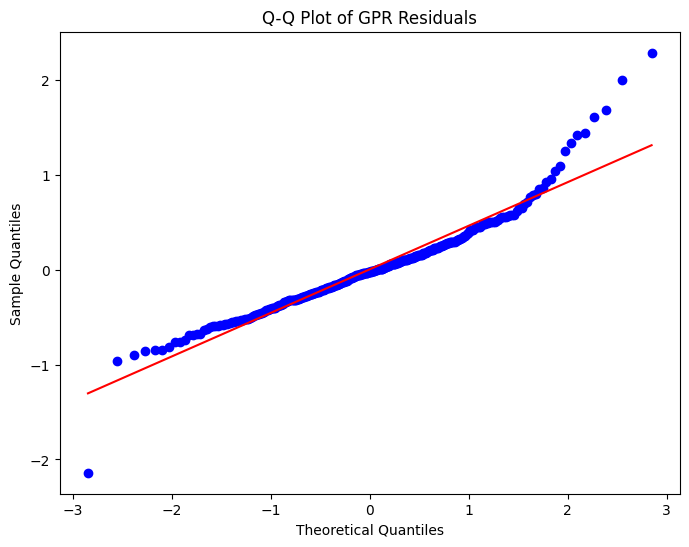

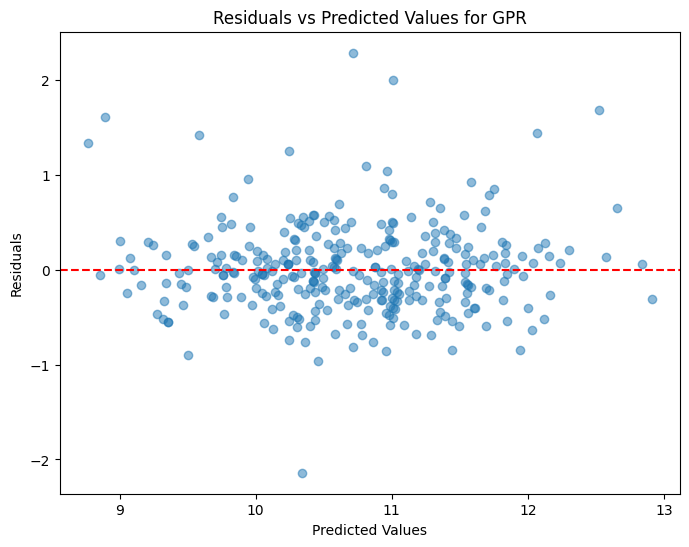

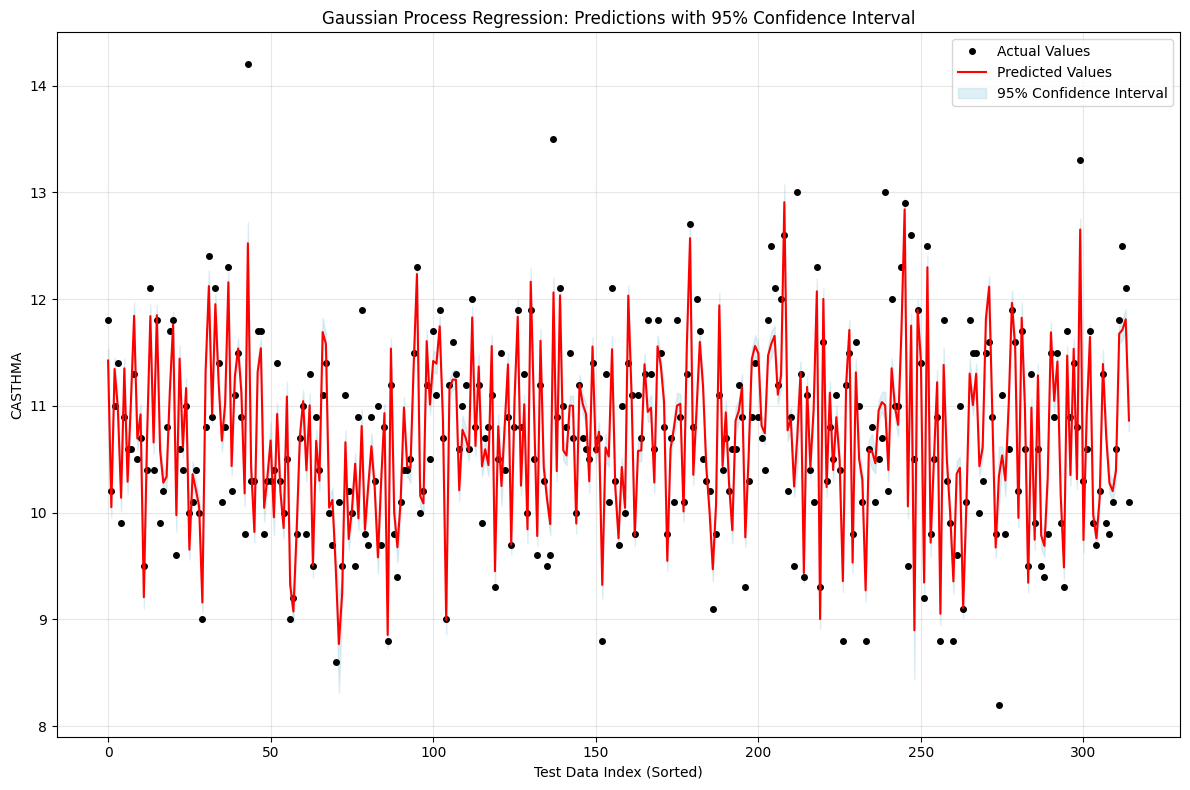

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, Matern
from scipy.stats import probplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# ---- Your setup ----
random_seed = 42
target = 'CASTHMA'

# Important features
selected_features = feature_selection(
    df, target, prevention_cols, behavior_cols, n=15, printGraph=False)
spatial_features = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']
spatial_features.extend(selected_features.tolist())

X = df[list(set(spatial_features))]
y = df[target]

# Splitting
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=0.8, random_state=random_seed)

# Scaling
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(x_train)
X_val_scaled = scaler_X.transform(x_val)
X_test_scaled = scaler_X.transform(x_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()

# ---- GPR with hyperparameter tuning ----
kernel_options = [
    1.0 * RBF(length_scale=np.random.uniform(0.1, 10)) +
    WhiteKernel(noise_level=np.random.uniform(0.001, 0.1)),
    1.0 * RationalQuadratic(length_scale=np.random.uniform(0.1, 10), alpha=np.random.uniform(
        0.1, 10)) + WhiteKernel(noise_level=np.random.uniform(0.001, 0.1)),
    1.0 * Matern(length_scale=np.random.uniform(0.1, 10), nu=1.5) +
    WhiteKernel(noise_level=np.random.uniform(0.001, 0.1))
]

param_grid = {'kernel': kernel_options}
gpr = GaussianProcessRegressor(
    n_restarts_optimizer=5, random_state=random_seed)
random_search = RandomizedSearchCV(
    gpr, param_distributions=param_grid, n_iter=10, cv=5, scoring='r2', random_state=random_seed, verbose=2, n_jobs=-1
)

# Train on validation set
random_search.fit(X_val_scaled, y_val_scaled)

best_gpr = random_search.best_estimator_
print(f"\nBest Kernel Found: {random_search.best_params_['kernel']}")

# Predict
y_pred_scaled, y_std_scaled = best_gpr.predict(X_test_scaled, return_std=True)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nGaussian Process Regression Results:")
print(f"Test R²: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")

# ---- Visualization ----

# Q-Q Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of GPR Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values for GPR")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Prediction Curve + Confidence Interval
sorted_indices = np.argsort(y_test.index)
y_test_sorted = y_test.values[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
y_std_sorted = y_std_scaled[sorted_indices]

plt.figure(figsize=(12, 8))
plt.plot(range(len(y_test_sorted)), y_test_sorted,
         'ko', markersize=4, label="Actual Values")
plt.plot(range(len(y_pred_sorted)), y_pred_sorted,
         'r-', linewidth=1.5, label="Predicted Values")
plt.fill_between(range(len(y_pred_sorted)),
                 y_pred_sorted - 1.96 * y_std_sorted,
                 y_pred_sorted + 1.96 * y_std_sorted,
                 color="lightblue", alpha=0.4, label="95% Confidence Interval")
plt.title("Gaussian Process Regression: Predictions with 95% Confidence Interval")
plt.xlabel("Test Data Index (Sorted)")
plt.ylabel("CASTHMA")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Gaussian Process Regression (GPR) was utilized to model the prevalence of current asthma (CASTHMA) by combining important behavioral, preventive, and spatial features. GPR offers a probabilistic, non-parametric approach that not only predicts target values but also quantifies uncertainty through confidence intervals.

The hyperparameter tuning process via RandomizedSearchCV selected the following optimal kernel:

- Best Kernel: 1**2 * Matern(length_scale=2.45, nu=1.5) + WhiteKernel(noise_level=0.0784)

This kernel combination allowed the model to balance smooth spatial variations (Matern kernel) with random noise (White kernel), making it highly suitable for geographically distributed health data.

The model achieved:

- Test R²: 0.7397

- Test MSE: 0.2231

As illustrated in the figure, the GPR predictions (red curve) closely follow the actual observed values (black points) across the test set. The 95% confidence intervals further demonstrate the model’s reliability and its ability to express uncertainty around predictions.

Despite slight variance in some regions, GPR successfully captured both large-scale trends and localized variations in asthma prevalence, outperforming simple baseline models while providing interpretability via uncertainty estimates.